# Linear Regression with Regularization

Regularization is a way to prevent overfitting and allows the model to generalize better.

Unlike polynomial fitting, it's hard to imagine how linear regression can overfit the data, since it's just a single line (or a hyperplane). One situation might be that features are **correlated** or redundant. Suppose there are two features, both are exactly the same, our predicted hyperplane will be in this format:

$$
\hat{y} = w_0 + w_1x_1 + w_2x_2
$$

and the true values of $x_2$ is almost the same as $x_1$ (or with some multiplicative factor and noise). Then, it's best to just drop $w_2x_2$ term and use:

$$
\hat{y} = w_0 + w_1x_1
$$

to fit the data. This is a simpler model.

But we don't know whether $x_1$ and $x_2$ is **actually** redundant or not, at least with bare eyes, and we don't want to manually drop a parameter just because we feel like it. We want to model to learn to do this itself, that is, to *prefer a simpler model that fits the data well enough*. 

To do this, we add a penalty term to our loss function. Two common penalty terms are L1 and L2.

### L2 Penalty

Recall the loss function of linear regression from [previous article](/blog_content/linear_regression/linear_regression_tutorial.html#writing-sse-loss-in-matrix-notation).

$$ 
L(w) = \sum_{i=1}^{n} \left( y^i - wx^i \right)^2
$$

we can add the **L2 penalty term** to it, and this is called **L2 regularization**.:

$$
L(w) = \sum_{i=1}^{n} \left( y^i - wx^i \right)^2 + \lambda\sum_{j=0}^{d}w_j^2
$$

This is called L2 penalty just because it's a L2-norm of $w$. In fancy term, this whole loss function is also known as **Ridge regression**.

Let's see what's going on. Loss function is something we **minimize**. Any terms that we add to it, we also want it to be minimized (that's why it's called *penalty term*). The above means we want $w$ that fits the data well (first term), but we also want the values of $w$ to be small as possible (second term). $\lambda$ (or whatever greek signs used) is to adjust how much to penalize $w$. It's impossible to know the appropriate value for lambda. You just have to try them out, in exponential range (0.01, 0.1, 1, 10, etc), then select the one that has the lowest loss on validation set, or doing k-fold cross validation.

Setting $\lambda$ to be very low means we don't penalize the complex model much. Setting it to $0$ is the vanilla linear regression. Setting it high means we strongly prefer simpler model, at the cost of how well it fits the data.


#### Closed-form solution
We can also write L2 regression in a nice matrix notation:

$$
L(w) = {\left\lVert y - Xw \right\rVert}^2 + \lambda{\left\lVert w \right\rVert}_2^2
$$

Then the gradient is:

$$
\nabla L_w = -2X^T(y-Xw) + 2\lambda w
$$

Setting to zero and solve:

$$
\begin{align}
0 &= -2X^T(y-Xw) + 2\lambda w \\
&= X^T(y-Xw) - \lambda w    \\ 
&= X^Ty - X^TXw - \lambda w \\
&= X^Ty - (X^TX + \lambda I_d) w
\end{align}
$$

Move that to other side and we get a closed-form solution:

$$
\begin{align}
(X^TX + \lambda I_d) w &= X^Ty    \\
w &= (X^TX + \lambda I_d)^{-1}X^Ty
\end{align}
$$

which is almost the same as linear regression without regularization.

### L1 Penalty
As you might guess, you can add L1-norm for **L1 regularization**:

$$
L(w) = \sum_{i=1}^{n} \left( y^i - wx^i \right)^2 + \lambda\sum_{j=0}^{d}\left|w_j\right|
$$

Again, in fancy term, this loss function is also known as **Lasso regression**. Using matrix notation:

$$
L(w) = {\left\lVert y - Xw \right\rVert}^2 + \lambda{\left\lVert w \right\rVert}_1
$$

It's more complex to get a closed-form solution for this, so we'll leave it here.

### L1 vs L2 Penalty

What's the point of using different penalty terms, as it seems like both try to push down the size of $w$.

Turns out L1 penalty tends to produce *sparse solutions*, which means most entries in $w$ are zeros. This is great if you want the model to be simple and compact.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(1)

Lambda = 0.2

True_w1 = 300
True_w0 = 500
def true_target(x):
  return True_w1*x + True_w0

def observed_target(x):
  """Underlying data with Gaussian noise added"""
  normal_noise = np.random.normal() * 6
  return true_target(x) + normal_noise

N = 50

# Features, X is [1,50]
# X = np.arange(N).reshape(N, 1)
X = np.random.rand(N).reshape(N, 1)

# Observed targets
y = np.array([observed_target(x) for x in X]).reshape(N, 1)

# Append 1 for intercept term later
X = np.hstack([np.ones((N, 1)), X])

from mpl_toolkits.mplot3d import Axes3D

# Ranges of w0 and w1 to see, centering at the true line
spanning_radius = np.max([True_w1, True_w0, 200])
step = 0.5
w0range = np.arange(True_w0-spanning_radius, True_w0+spanning_radius, step)
w1range = np.arange(True_w1-spanning_radius, True_w1+spanning_radius, step)
w0grid, w1grid = np.meshgrid(w0range, w1range)

range_len = len(w0range)
print("Number of values in each axis:", range_len)

# Make [w0, w1] in (2, 14400) shape
all_w0w1_values = np.hstack([w0grid.flatten()[:,None], w1grid.flatten()[:,None]]).T

# Compute raw losses
raw_losses = np.linalg.norm(y - (X @ all_w0w1_values), axis=0) ** 2
raw_losses = raw_losses.reshape((range_len, range_len))

# Compute L2 penalty losses
penalty_loss = Lambda * np.linalg.norm(all_w0w1_values, axis=0) ** 2
penalty_loss = penalty_loss.reshape((range_len, range_len))

Number of values in each axis: 2000


In [2]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

lr = LinearRegression(fit_intercept=False)
lr = lr.fit(X, y)

ridge = Ridge(alpha=Lambda)
ridge = ridge.fit(X, y)

lasso = Lasso(alpha=Lambda)
lasso = lasso.fit(X, y)

ridge_coef = ridge.coef_[0]
lasso_coef = lasso.coef_
lr_coef = lr.coef_[0]

print("Ridge solution:", ridge_coef)
print("Lasso solution:", lasso_coef)
print("Linear Regression solution:", lr_coef)

Ridge solution: [  0.         289.21906667]
Lasso solution: [  0.         299.48649757]
Linear Regression solution: [500.00853749 301.63252862]


In [3]:
ridge_loss = np.linalg.norm(y - X @ ridge_coef) ** 2 + Lambda * np.linalg.norm(ridge_coef, ord=2) ** 2
lasso_loss = np.linalg.norm(y - X @ lasso_coef) ** 2 + Lambda * np.linalg.norm(lasso_coef, ord=1)
lr_loss = np.linalg.norm(y - X @ lr_coef) ** 2

print("Ridge loss:", ridge_loss)
print("Lasso loss:", lasso_loss)
print("Linear Regression loss:", lr_loss)

Ridge loss: 680374639.5444187
Lasso loss: 669697965.9185725
Linear Regression loss: 42469207.783152446


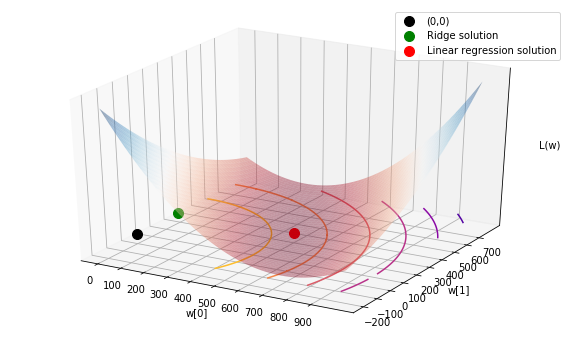

In [4]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')

ax.plot_surface(w0grid, w1grid, raw_losses, alpha=0.4, cmap='RdBu')
ax.contour(w0grid, w1grid, penalty_loss, alpha=1, cmap='plasma_r')

ax.scatter([0],[0], 0, c='black', s=100, label="(0,0)")

ax.scatter([ridge_coef[0]],[ridge_coef[1]], 0, c='green', s=100, label="Ridge solution")
ax.scatter([lr_coef[0]],[lr_coef[1]], 0, c='red', s=100, label="Linear regression solution")

ax.legend(loc='best')
ax.set_xlabel('w[0]')
ax.set_ylabel('w[1]')
ax.set_zlabel('L(w)')
ax.set_xticks(np.arange(True_w0-spanning_radius, True_w0+spanning_radius, 100))
ax.set_yticks(np.arange(True_w1-spanning_radius, True_w1+spanning_radius, 100))
ax.set_zticks([ridge_loss])
# plt.axis('off')
# ax.set_zlim(0, 20000)

plt.show()